In [1]:
import fenics as fe
import mshr
import cv2
import tlib.plot as tpl
import nrrd
import ipyvolume as ipv

In [2]:
'Generate snowman mesh'
vol = np.zeros(shape=(100, 100, 100), dtype='u1')
for x in range(100):
    for y in range(100):
        for z in range(100):
            cond_1 = (x-50)**2 + (y-50)**2 + (z-50)**2 < 200
            cond_2 = (x-40)**2 + (y-40)**2 + (z-50)**2 < 100
            if cond_1 or cond_2:
                vol[z, y, x] = 1
ipv.quickvolshow(vol)

/Users/tbiancal/miniconda3/envs/pde/lib/python3.7/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


- Export NRRD volume.
- Open in ImageJ with plugin 3D volume.
- `Edit->Display as->Surface`.
- Export surface as STL (I use binary).

In [3]:
# nrrd.write('vol.nrrd', vol*255)

In [4]:
from mshr import *

In [5]:
# Load surface from file
geometry = Surface3D("surface_ascii.stl")
domain = CSGCGALDomain3D(geometry)

In [6]:
generator = TetgenMeshGenerator3D()
generator.parameters["preserve_surface"] = True
generator.parameters["mesh_resolution"] = 10.

In [7]:
mesh = generator.generate(domain)

In [8]:
mesh

In [9]:
# define function space
V = fe.FunctionSpace(mesh, 'P', 1)  

# define Dirichlet BC
u_D = fe.Expression('-1', degree=2)
def boundary(x, on_boundary):
    return on_boundary
bc = fe.DirichletBC(V, u_D, boundary)

# cast to variational problem
u = fe.TrialFunction(V)
v = fe.TestFunction(V)
f = fe.Constant(-6.0)
a = fe.dot(fe.grad(u), fe.grad(v)) * fe.dx
L = f * v * fe.dx

In [10]:
# Compute solution
u = fe.Function(V)
fe.solve(a == L, u, bc)

In [11]:
# Save solution to file in VTK format
vtkfile = fe.File('poisson/snowman.pvd')
vtkfile << u

Problem: it's only on the surface

- Use gmsh to create mesh.
- How to integrate gmsh with fenics [link](http://mypages.iit.edu/~asriva13/?page_id=586).

In [12]:
import pygmsh

Other strategy: use pygcal.


Other strategy. use pre-defined mesh and define sub-domain

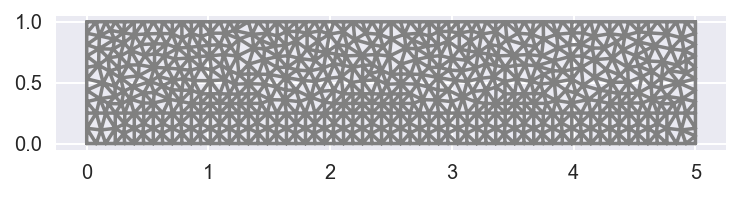

In [14]:
from dolfin import *
import mshr
import matplotlib.pyplot as plt
# Create the geometry
p0 = Point((0.,0))
p1 = Point((0,.25))
p2 = Point((5,.25))
p3 = Point((5,1))
r0 = mshr.Rectangle(p0,p2)
r1 = mshr.Rectangle(p1,p3)
geom = r0 + r1
# set subdomains
geom.set_subdomain(1,r0)
geom.set_subdomain(2,r1)
# generate mesh
mesh = mshr.generate_mesh(geom,30)
plot(mesh)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
The area of subdomain 1 is 1.250000e+00
The area of subdomain 2 is 3.750000e+00


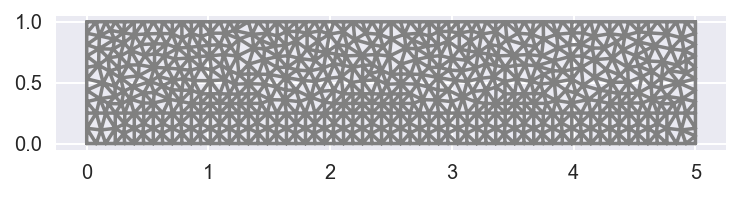

In [13]:
# define  the mesh function and the measure 
# including the labels 1 and 2 
domains = mesh.domains()
mf = MeshFunction('size_t',mesh,2,domains)
dx = Measure("dx",domain=mesh,subdomain_data=mf)
# Example, calculat the area of the rectangle
s1 = assemble(Constant(1)*dx(1))
s2 = assemble(Constant(1)*dx(2))
print("The area of subdomain 1 is {:2e}".format(s1))
print("The area of subdomain 2 is {:2e}".format(s2))

In [17]:
# Or creating a new mesh (make sure not to overwrite the `mesh` import by
# naming it `mesh`):
VERTICE_COUNT = 100
data = np.zeros(VERTICE_COUNT, dtype=mesh.Mesh.dtype)

AttributeError: 'dolfin.cpp.mesh.Mesh' object has no attribute 'Mesh'

In [16]:
your_mesh = mesh.Mesh(data, remove_empty_areas=False)

AttributeError: 'dolfin.cpp.mesh.Mesh' object has no attribute 'Mesh'

***
### Other strategy
-  from Constructive Solid Geometry (CSG) (chosen in 2D example) (but I cannot find a way to generalize to 3D volumes because I do not have the primitive that generalizes `Polygon`).
-  from surface files.
    - supported type `off`, `stl` and `vtp`. 
    - Use class `Surface3D`.
    - [Blog](https://pyscience.wordpress.com/2014/09/06/numpy-to-vtk-converting-your-numpy-arrays-to-vtk-arrays-and-files/) to convert between Numpy and VTK.
    - Follow [blog](https://pyscience.wordpress.com/2014/09/11/surface-extraction-creating-a-mesh-from-pixel-data-using-python-and-vtk/) to extract surface from tensor.
    

In [4]:
import vtk
from vtk.util import numpy_support

NumPy_data_shape = vol.shape
VTK_data = numpy_support.numpy_to_vtk(num_array=vol.ravel(), 
                                      deep=True, 
                                      array_type=vtk.VTK_FLOAT)

In [10]:
march_cubes = vtk.vtkDiscreteMarchingCubes()
march_cubes

(vtkFiltersGeneralPython.vtkDiscreteMarchingCubes)0x1345df228

In [11]:
from pyevtk.hl import gridToVTK
import numpy as np
import random as rnd

# Dimensions
nx, ny, nz = 6, 6, 2
lx, ly, lz = 1.0, 1.0, 1.0
dx, dy, dz = lx/nx, ly/ny, lz/nz

ncells = nx * ny * nz
npoints = (nx + 1) * (ny + 1) * (nz + 1)

# Coordinates
X = np.arange(0, lx + 0.1*dx, dx, dtype='float64')
Y = np.arange(0, ly + 0.1*dy, dy, dtype='float64')
Z = np.arange(0, lz + 0.1*dz, dz, dtype='float64')

x = np.zeros((nx + 1, ny + 1, nz + 1))
y = np.zeros((nx + 1, ny + 1, nz + 1))
z = np.zeros((nx + 1, ny + 1, nz + 1))

# We add some random fluctuation to make the grid
# more interesting
for k in range(nz + 1):
    for j in range(ny + 1):
        for i in range(nx + 1):
            x[i,j,k] = X[i] + (0.5 - rnd.random()) * 0.1 * dx 
            y[i,j,k] = Y[j] + (0.5 - rnd.random()) * 0.1 * dy
            z[i,j,k] = Z[k] + (0.5 - rnd.random()) * 0.1 * dz

# Variables
pressure = np.random.rand(ncells).reshape( (nx, ny, nz))
temp = np.random.rand(npoints).reshape( (nx + 1, ny + 1, nz + 1))

gridToVTK("./structured", x, y, z, cellData = {"pressure" : pressure}, pointData = {"temp" : temp})

'/Users/tbiancal/git/lung-ccf/tommaso/pdm/structured.vts'

In [27]:
'Other strategy use pyevtk'
from pyevtk.hl import gridToVTK
import numpy as np
import random as rnd

# Dimensions
nx, ny, nz = 6, 6, 2
lx, ly, lz = 1.0, 1.0, 1.0
dx, dy, dz = lx/nx, ly/ny, lz/nz

ncells = nx * ny * nz
npoints = (nx + 1) * (ny + 1) * (nz + 1)

# Coordinates
X = np.arange(0, lx + 0.1*dx, dx, dtype='float64')
Y = np.arange(0, ly + 0.1*dy, dy, dtype='float64')
Z = np.arange(0, lz + 0.1*dz, dz, dtype='float64')

x = np.zeros((nx + 1, ny + 1, nz + 1))
y = np.zeros((nx + 1, ny + 1, nz + 1))
z = np.zeros((nx + 1, ny + 1, nz + 1))

# We add some random fluctuation to make the grid
# more interesting
for k in range(nz + 1):
    for j in range(ny + 1):
        for i in range(nx + 1):
            x[i,j,k] = X[i] + (0.5 - rnd.random()) * 0.1 * dx 
            y[i,j,k] = Y[j] + (0.5 - rnd.random()) * 0.1 * dy
            z[i,j,k] = Z[k] + (0.5 - rnd.random()) * 0.1 * dz

# Variables
pressure = np.random.rand(ncells).reshape( (nx, ny, nz))
temp = np.random.rand(npoints).reshape( (nx + 1, ny + 1, nz + 1))

gridToVTK("./structured", x, y, z, 
          cellData = {"pressure" : pressure}, 
          pointData = {"temp" : temp})

'/Users/tbiancal/git/lung-ccf/tommaso/pdm/structured.vts'

In [32]:
import pyevtk.hl

In [33]:
pyevtk.hl.pointsToVTK?

Signature: pyevtk.hl.pointsToVTK(path, x, y, z, data)
Docstring:
Export points and associated data as an unstructured grid.

PARAMETERS:
    path: name of the file without extension where data should be saved.
    x, y, z: 1D arrays with coordinates of the points.
    data: dictionary with variables associated to each point.
          Keys should be the names of the variable stored in each array.
          All arrays must have the same number of elements.

RETURNS:
    Full path to saved file.
File:      ~/miniconda3/envs/pde/lib/python3.7/site-packages/pyevtk/hl.py
Type:      function


In [29]:
ipv.quickvolshow(y)

- Surface extraction from VTK [link](https://pyscience.wordpress.com/2014/09/11/surface-extraction-creating-a-mesh-from-pixel-data-using-python-and-vtk/)

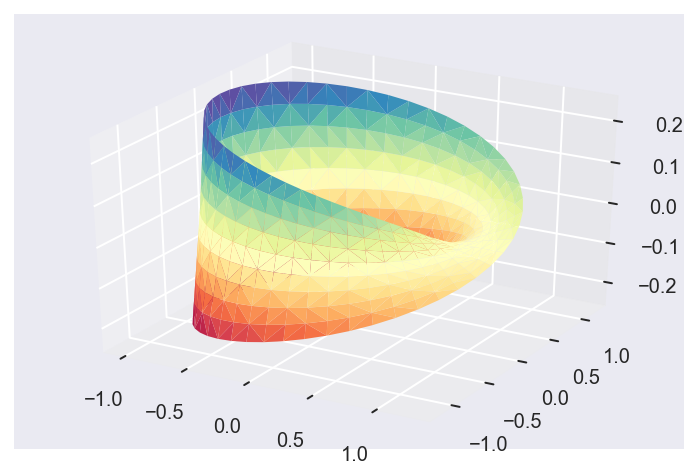

In [34]:
# %load http://matplotlib.org/mpl_examples/mplot3d/trisurf3d_demo2.py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri

# u, v are parameterisation variables
u = (np.linspace(0, 2.0 * np.pi, endpoint=True, num=50) * np.ones((10, 1))).flatten()
v = np.repeat(np.linspace(-0.5, 0.5, endpoint=True, num=10), repeats=50).flatten()

# This is the Mobius mapping, taking a u, v pair and returning an x, y, z
# triple
x = (1 + 0.5 * v * np.cos(u / 2.0)) * np.cos(u)
y = (1 + 0.5 * v * np.cos(u / 2.0)) * np.sin(u)
z = 0.5 * v * np.sin(u / 2.0)

# Triangulate parameter space to determine the triangles
tri = mtri.Triangulation(u, v)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

# The triangles in parameter space determine which x, y, z points are
# connected by an edge
mobius_polycollection = ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)

In [42]:
x.shape, y.shape, z.shape

((500,), (500,), (500,))

In [ ]:
# now convert mobius_polycollection to mesh
import stl

mobius_mesh = #I have no idea...

mobius_mesh.save('mobius.stl')

In [8]:
from dolfin import *

In [7]:
mshr.generate_mesh?

Docstring: generate_mesh(geoemtry: mshr.cpp.CSGGeometry, resolution: float, backend: str = 'cgal') -> dolfin.cpp.mesh.Mesh
Type:      builtin_function_or_method


In [15]:
mshr.Polygon

Docstring:      Variable base class
Init docstring: __init__(self: mshr.cpp.Polygon, arg0: List[dolfin.cpp.geometry.Point]) -> None
File:           ~/miniconda3/envs/pde/lib/python3.7/site-packages/mshr/cpp.cpython-37m-darwin.so
Type:           pybind11_type
Subclasses:     


In [ ]:
# Generate mesh on domain
mesh_resolution = 30
pts_pp = [fe.Point(pt[0],  pt[1]) for pt in pts]
pts_pp = list(reversed(pts_pp))  # counter-clockwise order
pol = mshr.Polygon(pts_pp)
mesh = mshr.generate_mesh(pol, mesh_resolution)
mesh

In [54]:
from dolfin import *

In [9]:
# Create empty Mesh
mesh = Mesh()

# Create list of polygonal domain vertices
domain_vertices = [Point(0.0, 0.0),
                   Point(10.0, 0.0),
                   Point(10.0, 2.0),
                   Point(8.0, 2.0),
                   Point(7.5, 1.0),
                   Point(2.5, 1.0),
                   Point(2.0, 4.0),
                   Point(0.0, 4.0),
                   Point(0.0, 0.0)]

In [12]:
mshr.generate_mesh(mesh, domain_vertices)

TypeError: generate_mesh(): incompatible function arguments. The following argument types are supported:
    1. (geoemtry: mshr.cpp.CSGGeometry, resolution: float, backend: str = 'cgal') -> dolfin.cpp.mesh.Mesh

Invoked with: <dolfin.cpp.mesh.Mesh object at 0x13758b620>, [<dolfin.cpp.geometry.Point object at 0x137aebf80>, <dolfin.cpp.geometry.Point object at 0x137aebca8>, <dolfin.cpp.geometry.Point object at 0x137aebfb8>, <dolfin.cpp.geometry.Point object at 0x137aebce0>, <dolfin.cpp.geometry.Point object at 0x137aebb90>, <dolfin.cpp.geometry.Point object at 0x137aebdc0>, <dolfin.cpp.geometry.Point object at 0x137aebd50>, <dolfin.cpp.geometry.Point object at 0x137aebe30>, <dolfin.cpp.geometry.Point object at 0x137aebd88>]

In [10]:
# Generate mesh and plot
PolygonalMeshGenerator.generate(mesh, domain_vertices, 0.25);

NameError: name 'PolygonalMeshGenerator' is not defined

In [56]:
plot(mesh, interactive=True)

# Generate 3D mesh from OFF file input (tetrahedron)
PolyhedralMeshGenerator.generate(mesh, "../tetrahedron.off", 0.05)
plot(mesh, interactive=True)

# Generate 3D mesh from OFF file input (cube)
PolyhedralMeshGenerator.generate(mesh, "../cube.off", 0.05)
plot(mesh, interactive=True)

NameError: name 'PolygonalMeshGenerator' is not defined